# Motivation/Purpose
The goal of this notebook is to load the data using pyspark, look at misclassified stations, correct any issues and then convert it into a by lane specific dataset.

Note: this code requires spark 2.0+


Section to document: Motivation/Purpose, tasks, work, results, conclusions/findings

In [10]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Import data types
from pyspark.sql.types import *
from pyspark.sql.functions import minute, hour, concat, col, lit, Column

# sparkConf = SparkConf()
# sparkConf.set("spark.ui.port", "4050")

#     .config("spark.driver.allowMultipleContexts", "true") \

# spark = SparkSession \
#     .builder \
#     .appName("moreTrafficData") \
#     .getOrCreate()

In [11]:
import pandas as pd
from time import time
%matplotlib inline

# Tasks
## Load the Data
## Explore the data for abnomialies
## Clean the data by adjusting any misclassified stations and values for flow
## Convert into a by lane aggregated dataset


In [12]:
!head -n 5 ../../data/meta_2015_with_elev.csv

,Unnamed: 0,Unnamed: 0.1,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
0,0,0,1113072,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,0.452,ML,2,Black Mountain Rd,314,,,,2015_01_01,178.243728638
1,1,1,1113073,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,,OR,3,BLACK MOUNTAIN RD,314,,,,2015_01_01,178.243728638
2,2,2,1113680,56,E,11,73,66000.0,6.862,7.364,32.953394,-117.133404,0.999,ML,3,BLACK MOUNTAIN RD,434,,,,2015_01_01,150.936233521
3,3,3,1113683,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,,FR,2,BLK MOUNTAIN - WB 56,314,,,,2015_01_01,178.243728638


In [13]:
# loaded the data using spark (for fun...)
meta_data = spark.read.csv('../../data/meta_2015_with_elev.csv',
                           inferSchema='true',
                           header='true',
                           sep=',',
                           encoding='utf-8',
                           timestampFormat='MM/dd/yyyy HH:mm:ss',
                         )

In [14]:
# # drop unnecessary columns
# meta_data = meta_data.drop('Unnamed: 0',
#                            'Unnamed: 0.1',
#                            'User_ID_1',
#                            'User_ID_2',
#                            'User_ID_3',
#                            'User_ID_4')

In [15]:
meta_df = meta_data.toPandas()

In [16]:
# meta_df

In [17]:
def create_freeway_vectors(frame_to_use, columns_to_select=['ID', 'Latitude', 'Longitude', 'Abs_PM', 'Lanes']):
    to_loop = frame_to_use.groupby(['Fwy', 'Dir'])['ID'].count().reset_index()[['Fwy', 'Dir']].values
    
    ret = {}
    for Fwy, Dir in to_loop:
        tmp = frame_to_use[(frame_to_use.Fwy == Fwy) & (frame_to_use.Dir == Dir)
                                                  & (frame_to_use.Type == 'ML')]\
            .sort_values(by='Abs_PM', ascending=True)[columns_to_select].drop_duplicates()
        tmp['order'] = pd.Series(index=tmp.index, data=sorted(range(0, len(tmp.ID)), reverse=False))
        ret["%s_%s" % (Fwy, Dir)] = tmp
    return ret 

In [18]:
freeway_vectors = create_freeway_vectors(meta_df)

In [19]:
# freeway_vectors

In [20]:
# meta_data.take(1)

### Create the schema

In [21]:
# Chris's Schema
# five_min_base_header = ['Timestamp', 'Station', 'District', 'Fwy', 'Direction', 'Lane_Type',
#                         'Station_Length', 'Samples', '%_Obser', 'Total_Flow', 'Avg_Occupancy', 'Avg_Speed']
# five_min_base_types = [TimestampType(), StringType(), StringType(), StringType(), StringType(), StringType(),
#                        FloatType(), StringType(), FloatType(), FloatType(), FloatType(), FloatType()]
# five_min_extra_header = ['Lane_%s_Samples', 'Lane_%s_Flow', 'Lane_%s_Avg_Occ', 'Lane_%s_Avg_Speed', 'Lane_%s_Observed']
# five_min_extra_types = [IntegerType(), FloatType(), FloatType(), FloatType(), FloatType()]

# fields = []
# for field_name, field_type in zip(five_min_base_header, five_min_base_types):
#     fields.append(StructField(field_name, field_type, True))

# max_lanes = 8
# for i in range(1, max_lanes + 1):
#     new_header = [item % i for item in five_min_extra_header]
#     for field_name, field_type in zip(new_header, five_min_extra_types):
#         fields.append(StructField(field_name, field_type, True))    

# schema = StructType(fields)
# schema

In [22]:
# Abe's schema
struct_list = [
   StructField("timestamp",TimestampType(),True),
   StructField("station",IntegerType(),True),
   StructField("district",IntegerType(),True),
   StructField("freeway",IntegerType(),True),
   StructField("direction_of_travel",StringType(),True),
   StructField("lanetype",StringType(),True),
   StructField("stationlength",DoubleType(),True),
   StructField("samples",IntegerType(),True),
   StructField("perc_observed",IntegerType(),True),
   StructField("totalflow",IntegerType(),True),
   StructField("avgoccupancy",DoubleType(),True),
   StructField("avgspeed",DoubleType(),True),
   StructField("lane1_samples",IntegerType(),True),
   StructField("lane1_flow",IntegerType(),True),
   StructField("lane1_avgocc",DoubleType(),True),
   StructField("lane1_avgspeed",DoubleType(),True),
   StructField("lane1_observed",IntegerType(),True),
   StructField("lane2_samples",IntegerType(),True),
   StructField("lane2_flow",IntegerType(),True),
   StructField("lane2_avgocc",DoubleType(),True),
   StructField("lane2_avgspeed",DoubleType(),True),
   StructField("lane2_observed",IntegerType(),True),
   StructField("lane3_samples",IntegerType(),True),
   StructField("lane3_flow",IntegerType(),True),
   StructField("lane3_avgocc",DoubleType(),True),
   StructField("lane3_avgspeed",DoubleType(),True),
   StructField("lane3_observed",IntegerType(),True),
   StructField("lane4_samples",IntegerType(),True),
   StructField("lane4_flow",IntegerType(),True),
   StructField("lane4_avgocc",DoubleType(),True),
   StructField("lane4_avgspeed",DoubleType(),True),
   StructField("lane4_observed",IntegerType(),True),
   StructField("lane5_samples",IntegerType(),True),
   StructField("lane5_flow",IntegerType(),True),
   StructField("lane5_avgocc",DoubleType(),True),
   StructField("lane5_avgspeed",DoubleType(),True),
   StructField("lane5_observed",IntegerType(),True),
   StructField("lane6_samples",IntegerType(),True),
   StructField("lane6_flow",IntegerType(),True),
   StructField("lane6_avgocc",DoubleType(),True),
   StructField("lane6_avgspeed",DoubleType(),True),
   StructField("lane6_observed",IntegerType(),True),
   StructField("lane7_samples",IntegerType(),True),
   StructField("lane7_flow",IntegerType(),True),
   StructField("lane7_avgocc",DoubleType(),True),
   StructField("lane7_avgspeed",DoubleType(),True),
   StructField("lane7_observed",IntegerType(),True),
   StructField("lane8_samples",IntegerType(),True),
   StructField("lane8_flow",IntegerType(),True),
   StructField("lane8_avgocc",DoubleType(),True),
   StructField("lane8_avgspeed",DoubleType(),True),
   StructField("lane8_observed",IntegerType(),True)
]
schema = StructType(struct_list)

## Read a single file

In [23]:
# path to the 5min data files
# !ls ../../../../cohort2/output/station_5min/2015/d11

In [24]:
# review the file
single_file = '../../../../cohort2/output/station_5min/2015/d11/d11_text_station_5min_2015_01_01.txt.gz'
all_files = '../../../../cohort2/output/station_5min/2015/d11/*.txt.gz'
# first_file = sc.textFile(single_file)
# first_file.take(1)

In [62]:
start_time = time()
data = spark.read.csv(all_files,
                      inferSchema='false',
                      schema=schema,
                      sep=',',
                      encoding='utf-8',
                      timestampFormat='MM/dd/yyyy HH:mm:ss',
                     )
# data = spark.read.csv(all_files, schema=schema, sep=',', encoding='utf-8')

# convert timestamp to time only column
data = (data
        .withColumn("minute", minute(data['Timestamp']).cast("int"))
        .withColumn("hour", hour(data['Timestamp']).cast("int")))
# tmp = data.first()
# print tmp
# print type(tmp.hour)

data = (data
        .withColumn('Time', concat(data.hour, lit(":"), data.minute))
        .withColumn('TimeNumber', data.hour * 12 + data.minute/5))
# data = (data.withColumn('Time', data['hour'] + ':' + data['minute']))

# print data.take(1)

# Creates a temporary view using the DataFrame
# data.createOrReplaceTempView("data")

# SQL can be run over DataFrames that have been registered as a table.
# results = spark.sql("SELECT count(Station) as cnt FROM data")

# results.show()

# result_by_time = data.groupBy(['Station', 'TimeNumber']).agg({'totalflow': 'mean'}).toPandas()
# filter to 5:00 am to 9:00 pm to account for the stations that go offline during the evening.
# result_avg = data.filter((21 >= data.hour) & (data.hour >= 5)).groupBy(['Station']).agg(    
result_avg = data.filter((21 >= data.hour) & (data.hour >= 5) & (data.perc_observed >= 100)).groupBy(['Station']).agg(
    {'totalflow': 'mean',
     'perc_observed': 'mean',
     'samples': 'mean',
     'lane1_flow': 'mean',
     'lane2_flow': 'mean',
     'lane3_flow': 'mean',
     'lane4_flow': 'mean',
     'lane5_flow': 'mean',
     'lane6_flow': 'mean',                                            
     'lane7_flow': 'mean',
     'lane8_flow': 'mean'}).toPandas()
print "total time: %s" % (time() - start_time)

total time: 1198.88023901


## Explore the Data
Observations:
* Data for each hour varies across even a single day
* The values for flow when no samples are records can be over 2x off
* The metadata includes 1541 stations in D11 (San Diego) yet not all of them have data for each day

#### Distribution of Types of stations

| Lane Type | Count of Station | Lane Type Full Name |
|-----------|------------------|---------------------|
| ML        | 839              | Mainline
| OR        | 312              | On Ramp
| FR        | 234              | Off Ramp
| HV        | 93               | HOV
| FF        | 55               | Fwy-Fwy connector
| CH        | 7                | Conventional Highway
| CD        | 1                | Collector/Distributor

Note: The number of on ramps is 33% higher than the number of off ramps, which means that unless the off ramps have more lanes, the D11 inflow capacity exceeds the D11 out flow capacity

In [63]:
# sort the columns
result_avg = result_avg.reindex_axis(sorted(result_avg.columns), axis=1)

In [64]:
merged_result_avg = pd.merge(result_avg, meta_df, how='left', left_on='Station', right_on='ID')

In [65]:
merged_result_avg[merged_result_avg.Station == 1108609].head()

,Station,avg(lane1_flow),avg(lane2_flow),avg(lane3_flow),avg(lane4_flow),avg(lane5_flow),avg(lane6_flow),avg(lane7_flow),avg(lane8_flow),avg(perc_observed),...,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
965,1108609,56.757242,80.199934,81.77953,73.58106,NaN,NaN,NaN,None,100.0,...,0.387,ML,4,HANCOCK ST,10407,None,None,None,2015_12_17,25.888737


In [66]:
ret = result_avg[result_avg['avg(samples)'] < 5]
print "# of stations that have less than an average of 5 samples per 5 minutes: %s" % len(ret)
# ret

# of stations that have less than an average of 5 samples per 5 minutes: 1


### Review the aggregate flow for a single freeway

In [67]:
merged_result_avg.columns

Index([u'Station', u'avg(lane1_flow)', u'avg(lane2_flow)', u'avg(lane3_flow)',
       u'avg(lane4_flow)', u'avg(lane5_flow)', u'avg(lane6_flow)',
       u'avg(lane7_flow)', u'avg(lane8_flow)', u'avg(perc_observed)',
       u'avg(samples)', u'avg(totalflow)', u'_c0', u'Unnamed: 0',
       u'Unnamed: 0.1', u'ID', u'Fwy', u'Dir', u'District', u'County', u'City',
       u'State_PM', u'Abs_PM', u'Latitude', u'Longitude', u'Length', u'Type',
       u'Lanes', u'Name', u'User_ID_1', u'User_ID_2', u'User_ID_3',
       u'User_ID_4', u'file_date', u'elevation'],
      dtype='object')

In [68]:
# Let's look at a single freeway / direction, ie: 56 W
W_56 = merged_result_avg[(merged_result_avg.Dir == 'W') & (merged_result_avg.Fwy == 56)]
W_56.Lanes.unique()

array([2, 3, 4, 1])

In [69]:
W_56.groupby('Type').count()

,Station,avg(lane1_flow),avg(lane2_flow),avg(lane3_flow),avg(lane4_flow),avg(lane5_flow),avg(lane6_flow),avg(lane7_flow),avg(lane8_flow),avg(perc_observed),...,Longitude,Length,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
Type,,,,,,,,,,,,,,,,,,,,,
FR,4,4,2,0,0,0,0,0,0,4,...,4,0,4,4,4,0,0,0,4,4
ML,9,9,9,0,0,0,0,0,0,9,...,9,9,9,9,9,0,0,0,9,9
OR,5,5,4,1,0,0,0,0,0,5,...,5,0,5,5,5,0,0,0,5,5


In [70]:
OR_W_56 = W_56[(W_56.Type == 'OR')].sort_values(by='Abs_PM', ascending=False)[
    ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)',
     'avg(totalflow)', 'avg(lane1_flow)', 'avg(lane2_flow)', 'avg(lane3_flow)',
     'Latitude', 'Longitude']]
W_56_in_flow = OR_W_56['avg(totalflow)'].mean()
print "the total flow into 56_W: %s" % W_56_in_flow
OR_W_56

the total flow into 56_W: 29.8040269228


,Station,Abs_PM,Lanes,avg(samples),avg(perc_observed),avg(totalflow),avg(lane1_flow),avg(lane2_flow),avg(lane3_flow),Latitude,Longitude
388,1125543,8.565,1,9.879941,100.0,31.631334,31.631334,NaN,NaN,32.958653,-117.113729
477,1113765,5.948,2,19.758150,100.0,14.412444,1.602456,12.809988,NaN,32.960479,-117.155182
137,1113723,2.909,3,29.637341,100.0,35.840641,4.953003,13.640109,17.247528,32.951299,-117.197463
786,1108746,1.861,2,19.757942,100.0,36.371831,10.850094,25.521737,NaN,32.944421,-117.213509
898,1108744,0.871,2,19.757298,100.0,30.763885,10.690455,20.073431,NaN,32.937625,-117.228312


In [71]:
FR_W_56 = W_56[(W_56.Type == 'FR')].sort_values(by='Abs_PM', ascending=False)[
    ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)',
     'avg(totalflow)', 'avg(lane1_flow)', 'avg(lane2_flow)', 'avg(lane3_flow)', 'avg(lane4_flow)']]
W_56_out_flow = FR_W_56['avg(totalflow)'].mean()
print "the total flow out of 56_W: %s" % W_56_out_flow
FR_W_56

the total flow out of 56_W: 19.7268525776


,Station,Abs_PM,Lanes,avg(samples),avg(perc_observed),avg(totalflow),avg(lane1_flow),avg(lane2_flow),avg(lane3_flow),avg(lane4_flow)
405,1125548,8.565,1,9.879941,100.0,19.915661,19.915661,NaN,NaN,NaN
171,1113764,5.948,4,19.758150,100.0,39.437963,9.965020,29.472944,NaN,NaN
1318,1113721,2.909,2,19.758228,100.0,3.115778,0.743673,2.372105,NaN,NaN
805,1113615,0.871,1,9.878649,100.0,16.438008,16.438008,NaN,NaN,NaN


In [72]:
ML_W_56 = W_56[(W_56.Type == 'ML')].sort_values(by='Abs_PM', ascending=False)[
    ['Station', 'Abs_PM', 'avg(samples)', 'avg(perc_observed)',
     'avg(totalflow)', 'avg(lane1_flow)', 'avg(lane2_flow)']]
W_56_main_flow = ML_W_56['avg(totalflow)'].mean()
print "total 56 W flow is: %s" % W_56_main_flow
ML_W_56

total 56 W flow is: 143.954109526


,Station,Abs_PM,avg(samples),avg(perc_observed),avg(totalflow),avg(lane1_flow),avg(lane2_flow)
98,1125531,9.302,19.752533,100.0,158.144638,65.109398,93.035240
849,1125546,8.565,19.756190,100.0,138.233397,67.247084,70.986312
214,1125575,7.661,19.755641,100.0,125.649981,64.198317,61.451664
665,1125219,6.175,19.756935,100.0,129.411061,68.685790,60.725272
874,1113760,5.948,19.754806,100.0,130.273411,69.318198,60.955212
882,1113771,4.519,19.745703,100.0,154.590137,79.855364,74.734774
1343,1113720,2.909,19.754950,100.0,139.494396,70.147627,69.346768
155,1108745,1.861,19.750775,100.0,149.996062,74.368454,75.627608
845,1108743,0.881,19.752777,100.0,169.793903,70.592726,99.201177


In [73]:
print "the total flow into 56_W: %s" % W_56_in_flow
print "the total flow out of 56_W: %s" % W_56_out_flow
print "total 56 W flow is: %s" % W_56_main_flow
print "total in flow vs total out flow: %s" % (W_56_in_flow / W_56_out_flow)
print "total main flow vs total in flow: %s" % (W_56_main_flow / W_56_in_flow)
print "total main flow vs total out flow: %s" % (W_56_main_flow / W_56_out_flow)

the total flow into 56_W: 29.8040269228
the total flow out of 56_W: 19.7268525776
total 56 W flow is: 143.954109526
total in flow vs total out flow: 1.5108353857
total main flow vs total in flow: 4.83002212752
total main flow vs total out flow: 7.29736834399


In [99]:
# print stats for all freeways
freeway_stats = {}
for freeway_key in freeway_vectors:
    freeway_stats[freeway_key] = {}
    fwy_num, fwy_dir = freeway_key.split('_')
    
    for fwy_type in ['OR', 'FR', 'ML']:
        if fwy_type == 'OR':
            store_key = 'in_flow'
        elif fwy_type == 'FR':
            store_key = 'out_flow'
        else:
            store_key = 'thru_flow'

        lane_flows = {}
        freeway_data = merged_result_avg[(merged_result_avg.Dir == fwy_dir) & (merged_result_avg.Fwy == int(fwy_num))]
        freeway_filter = freeway_data[(freeway_data.Type == fwy_type)].sort_values(by='Abs_PM', ascending=False)[
            ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)', 'avg(totalflow)',
             'avg(lane1_flow)', 'avg(lane2_flow)', 'avg(lane3_flow)', 'avg(lane4_flow)', 'avg(lane5_flow)',
             'avg(lane6_flow)', 'avg(lane7_flow)', 'avg(lane8_flow)', 'Latitude', 'Longitude']]
        lane_flows['total'] = freeway_filter['avg(totalflow)'].mean()
        print "%s %s: %s" % (store_key, freeway_key, lane_flows['total'])
        for index in range(1, 8):
            lane_flows['lane%s' % index] = freeway_filter['avg(lane%s_flow)' % index].mean()
        freeway_stats[freeway_key][store_key] = lane_flows
    

in_flow 125_S: 40.328912289
out_flow 125_S: 36.7693526116
thru_flow 125_S: 129.584574238
in_flow 905_E: 5.52178728218
out_flow 905_E: 21.3397483999
thru_flow 905_E: 91.4131433417
in_flow 54_W: 45.9788582605
out_flow 54_W: 18.0408744969
thru_flow 54_W: 243.374359719
in_flow 125_N: 36.9175916519
out_flow 125_N: 32.6755771822
thru_flow 125_N: 130.745579885
in_flow 52_W: nan
out_flow 52_W: nan
thru_flow 52_W: 188.371151401
in_flow 67_N: nan
out_flow 67_N: nan
thru_flow 67_N: nan
in_flow 56_E: 36.5308036595
out_flow 56_E: 35.4873172921
thru_flow 56_E: 142.759719171
in_flow 67_S: nan
out_flow 67_S: nan
thru_flow 67_S: nan
in_flow 56_W: 29.8040269228
out_flow 56_W: 19.7268525776
thru_flow 56_W: 143.954109526
in_flow 905_W: 29.499562305
out_flow 905_W: 7.33772488145
thru_flow 905_W: 113.429411351
in_flow 94_E: 34.6204590627
out_flow 94_E: 42.6787691381
thru_flow 94_E: 270.884066642
in_flow 52_E: nan
out_flow 52_E: 13.8972631985
thru_flow 52_E: 193.97874111
in_flow 78_W: 39.4858098041
out_flow 

In [98]:
freeway_stats

{u'125_S': {'in_flow': {'lane1': 12.79924986821516,
   'lane2': 22.8986811967191,
   'lane3': 35.247964460944694,
   'lane4': nan,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 40.32891228901885},
  'out_flow': {'lane1': 17.16245684582846,
   'lane2': 26.14252768764368,
   'lane3': nan,
   'lane4': nan,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 36.76935261156122},
  'thru_flow': {'lane1': 40.72948575533675,
   'lane2': 52.06454676803742,
   'lane3': 52.859493847962334,
   'lane4': 9.735832764647716,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 129.58457423799118}}}

# Iterations for 56 W

## Iteration 1 = 1 day of data (no filtering on % observed)
* the total flow into 56_W: 14.8556701031
* the total flow out of 56_W: 4.44845360825
* total 56 W flow is: 143.935866013
* total in flow vs total out flow: 3.33951332561
* total main flow vs total in flow: 9.68895142489
* total main flow vs total out flow: 32.3563823946

## Iteration 2 = 1 year of data (no filtering on % observed)
* the total flow into 56_W: 29.8040269228
* the total flow out of 56_W: 18.1266616983
* total 56 W flow is: 151.0211851
* total in flow vs total out flow: 1.64420936513
* total main flow vs total in flow: 5.06714027241
* total main flow vs total out flow: 8.33143949031

## Iteration 3 = 1 year of data filtering to >= 50% % observed
* the total flow into 56_W: 29.8040269228
* the total flow out of 56_W: 18.1266616983
* total 56 W flow is: 144.642039981
* total in flow vs total out flow: 1.64420936513
* total main flow vs total in flow: 4.85310392304
* total main flow vs total out flow: 7.97951892021

## Iteration 4 = 1 year of data filtering to >= 80% % observed
* the total flow into 56_W: 29.8040269228
* the total flow out of 56_W: 19.7268525776
* total 56 W flow is: 143.954109526
* total in flow vs total out flow: 1.5108353857
* total main flow vs total in flow: 4.83002212752
* total main flow vs total out flow: 7.29736834399

## Iteration 5 = 1 year of data filtering to >= 100% % observed
* the total flow into 56_W: 29.8040269228
* the total flow out of 56_W: 19.7268525776
* total 56 W flow is: 143.954109526
* total in flow vs total out flow: 1.5108353857
* total main flow vs total in flow: 4.83002212752
* total main flow vs total out flow: 7.29736834399

From the runs above it appears that filtering upon data that is raw ie: 100% % observed gives us a closer ratio of main flow to the in flow and out flow, although the changes are small, and this is only a single freeway. However, for this notebook the assumption will be made that this is a consistent trend, until additional runs can be made on the cluster to confirm / disprove this theory.

### Data Exploration at this point
We can see that the number of on ramps and off ramps are the same for the 56 W and yet the total inflow is 3x higher than the 56 W total outflow. The total main line flow is ~10x higher than the total inflow and ~32x higher than the total outflow. Obviously this doesn't make sense in terms of the data, but given the geography of the freeway there are a few hints to the issue.

The 56 W begins from a surface street called Ted Williams Pkwy and Ends at the 5. The first station considered part of the 56 doesn't include the flow into the 5 and the last off ramp is prior where the 56 and 15 meet. So in theory the all of the flow that isn't going out via the off ramps is going into the 5 or 15 or Ted Williams Pkwy.

This means that we need to include a few stations from the other freeways to analyze the 56 West

### Add 15N/S and 5N/S that apply to the 56 West
Unfortunately we aren't able to add in the flow from Freeway to Freeway connectors since Caltrans doesn't have that data.

In [87]:
FF_data = merged_result_avg[(merged_result_avg.Type == 'FF')][[
        'Station', 'Fwy', 'Dir', 'Abs_PM', 'Latitude', 'Longitude', 'avg(totalflow)',
        'Name']].sort_values(by='Abs_PM', ascending=False)
# FF_data
# 1125692 = 56 W hits 5N and 1113026 = 56 W hits 5S
# Note: these don't show up due to filtering on % observed.
FF_data[(FF_data.Station == 1125692) | (FF_data.Station == 1113026)]

# For the 15 side there isn't a FF that maps to the 56 / 15 merge, so we have to use the difference between
# stations to calculate the flow
# Note: this still isn't a complete picture since cars can go straight and continue on ted williams or take
# other surface streets

# 1123002 - 1113985 = 15N component
# 1108429 - 1123003 = 15S component

N15_56W_start = merged_result_avg[(merged_result_avg.Station == 1123002)]['avg(totalflow)'].values[0]
print N15_56W_start
N15_56W_end = merged_result_avg[(merged_result_avg.Station == 1113985)]['avg(totalflow)'].values[0]
print N15_56W_end
total_N15 = N15_56W_start - N15_56W_end
print total_N15

S15_56W_start = merged_result_avg[(merged_result_avg.Station == 1108429)]['avg(totalflow)'].values[0]
print S15_56W_start
S15_56W_end = merged_result_avg[(merged_result_avg.Station == 1123003)]['avg(totalflow)'].values[0]
print S15_56W_end
total_S15 = S15_56W_start - S15_56W_end
print total_S15

print "total 15 flow from 56: %s" % (total_N15 + total_S15)

539.255150199
445.035415219
94.2197349799
445.164697621
538.332720544
-93.1680229237
total 15 flow from 56: 1.05171205618


### Data validation
Since we can't fully validate the data as part of a closed system model (since we don't have all of the inputs and outputs) we can at least try to determine if any data points aren't internally consistent. The approach would be to create a linear approximately and see if anything isn't along the line.

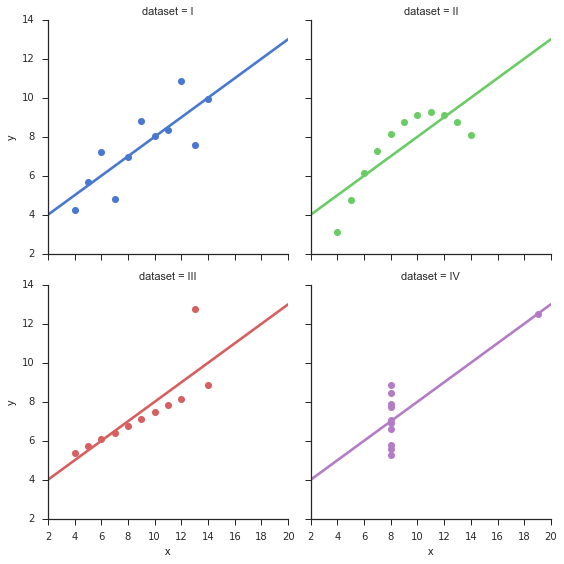

In [249]:
import seaborn as sns
sns.set(style="ticks")

# Load the example dataset for Anscombe's quartet
df = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 1})

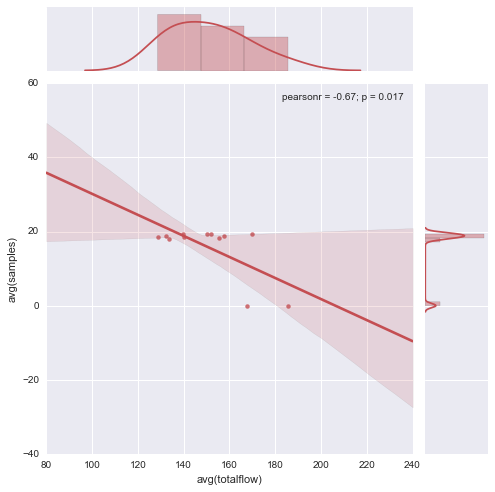

In [30]:
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# tips = sns.load_dataset("tips")
g = sns.jointplot("avg(totalflow)", "avg(samples)", data=ML_W_56, kind="reg", color="r", size=7)

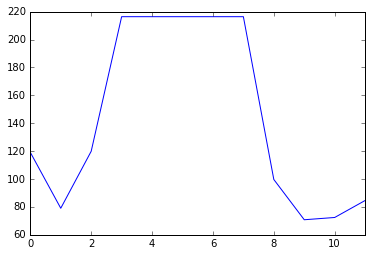

In [243]:
ML_W_56.index = range(0, len(ML_W_56))
ML_W_56['avg(totalflow)'].plot(kind='line')

In [ ]:
OR_W_56 = W_56[(W_56.Type == 'OR')].sort_values(by='Abs_PM', ascending=False)[
    ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)',
     'avg(totalflow)', 'avg(lane1_flow)', 'avg(lane2_flow)']]
W_56_in_flow = OR_W_56['avg(totalflow)'].mean()
print "the total flow into 56_W: %s" % W_56_in_flow
OR_W_56

In [ ]:
net_flow_to_5 = 

In [123]:
avg_W_56 = core_W_56[['avg(samples)', 'avg(perc_observed)', 'avg(totalflow)', 'avg(lane1_flow)',
                      'avg(lane2_flow)']].mean()
avg_W_56

avg(samples)            7.526620
avg(perc_observed)     34.895833
avg(totalflow)        130.785880
avg(lane1_flow)        63.920139
avg(lane2_flow)        66.865741
dtype: float64

In [220]:
# data.printSchema()

## Outlier Detection



An interactive shell.

This file is designed to be launched as a PYTHONSTARTUP script.



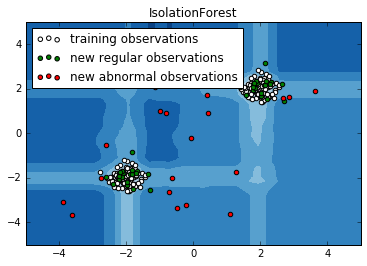

In [88]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble.iforest import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

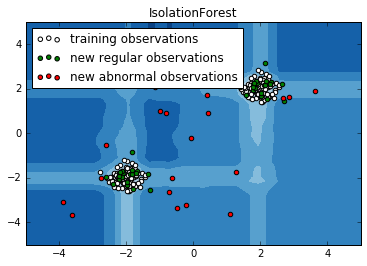

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble.iforest import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

In [95]:
29121

In [114]:
from pyspark.sql.functions import minute, hour

transformed = (data
#     .withColumn("ts",
#         unix_timestamp(col("Timestamp"), "MM/dd/yyyy hh:mm:ss").cast("timestamp"))
#     .withColumn("day", dayofmonth(col("ts")).cast("string"))
#     .withColumn("month", date_format(col("ts"), "MMM"))
    .withColumn("minute", minute(data['Timestamp']).cast("string"))
)

print transformed.take(1)

[Row(Timestamp=datetime.datetime(2015, 1, 1, 0, 0), Station=u'1100313', District=u'11', Fwy=u'5', Direction=u'N', Lane_Type=u'FR', Station_Length=None, Lane_1_Samples=10, Lane_1_Flow=100.0, Lane_1_Avg_Occ=16.0, Lane_1_Avg_Speed=None, Lane_1_Observed=None, Lane_2_Samples=10, Lane_2_Flow=16.0, Lane_2_Avg_Occ=None, Lane_2_Avg_Speed=None, Lane_2_Observed=1.0, Lane_3_Samples=None, Lane_3_Flow=None, Lane_3_Avg_Occ=None, Lane_3_Avg_Speed=None, Lane_3_Observed=0.0, Lane_4_Samples=None, Lane_4_Flow=None, Lane_4_Avg_Occ=None, Lane_4_Avg_Speed=None, Lane_4_Observed=0.0, Lane_5_Samples=None, Lane_5_Flow=None, Lane_5_Avg_Occ=None, Lane_5_Avg_Speed=None, Lane_5_Observed=0.0, Lane_6_Samples=None, Lane_6_Flow=None, Lane_6_Avg_Occ=None, Lane_6_Avg_Speed=None, Lane_6_Observed=0.0, Lane_7_Samples=None, Lane_7_Flow=None, Lane_7_Avg_Occ=None, Lane_7_Avg_Speed=None, Lane_7_Observed=0.0, Lane_8_Samples=None, Lane_8_Flow=None, Lane_8_Avg_Occ=None, Lane_8_Avg_Speed=None, Lane_8_Observed=0.0, ts=datetime.dateti

In [ ]:
print transformed.take

In [ ]:
# path_to_data = '../../../../cohort2/output/station_5min/2015/d11'
# raw_data = sc.textFile(path_to_data + "*.txt.gz") \
#     .map(lambda line: line.split(",")) \
#     .filter(lambda line: len(line)>1) \
#     .map(lambda line: (line[0],line[1])) \
#     .collect()

In [ ]:
# sentences=textRDD.flatMap(lambda x: x.split(". ")).map(lambda x: x.encode('utf-8'))